In [1]:
# !pwd
# install needed packages version 0.2.7
# !pip install pandas_ml_utils==0.2.7 pandas_ml_utils_torch==0.2.7 pandas_ml_quant==0.2.7 pandas_ta_quant==0.2.7 pandas_quant_data_provider

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
try:
    import pandas_ml_quant
except Exception as e:
    from include_pycharm_modules import import_source_folders
    import_source_folders("/home/kic/sources/private/projects/pandas-quant")
    import pandas_ml_quant
    
print(pandas_ml_quant.__version__)

import numpy as np
import matplotlib.pyplot as plt
from pandas_ml_utils import pd
import pandas_quant_data_provider as qd

You should consider upgrading via the '/home/kic/sources/private/projects/pandas-quant/.venv/bin/python -m pip install --upgrade pip' command.
automatically imported pandas_quant_data_provider 0.2.7
automatically imported pandas_ta_quant_plot 0.2.7


('Requirement already satisfied: yfinance in /home/kic/sources/private/projects/pandas-quant/.venv/lib/python3.8/site-packages (0.1.63)\nRequirement already satisfied: pandas>=0.24 in /home/kic/sources/private/projects/pandas-quant/.venv/lib/python3.8/site-packages (from yfinance) (1.2.4)\nRequirement already satisfied: multitasking>=0.0.7 in /home/kic/.local/lib/python3.8/site-packages (from yfinance) (0.0.9)\nRequirement already satisfied: numpy>=1.15 in /home/kic/sources/private/projects/pandas-quant/.venv/lib/python3.8/site-packages (from yfinance) (1.20.3)\nRequirement already satisfied: lxml>=4.5.1 in /home/kic/.local/lib/python3.8/site-packages (from yfinance) (4.5.1)\nRequirement already satisfied: requests>=2.20 in /home/kic/.local/lib/python3.8/site-packages (from yfinance) (2.23.0)\nRequirement already satisfied: pytz>=2017.3 in /home/kic/.local/lib/python3.8/site-packages (from pandas>=0.24->yfinance) (2020.1)\nRequirement already satisfied: python-dateutil>=2.7.3 in /home/

0.4595702742049743


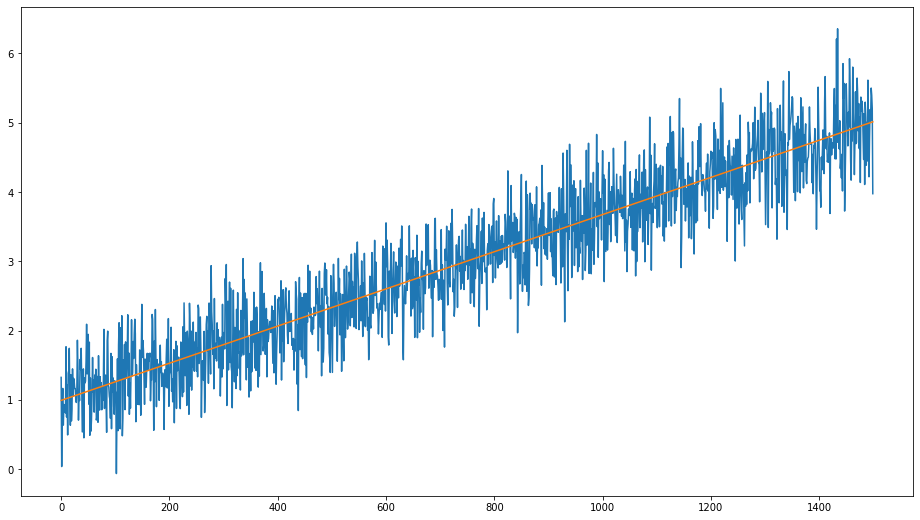

In [3]:
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

N = 1500
x = np.arange(0, N).reshape((-1, 1))
y = np.random.normal(0, 0.456, N) + np.linspace(1, 5, N)

regr = linear_model.LinearRegression().fit(x, y)

plt.figure(figsize=(16, 9))
plt.plot(y)
plt.plot(regr.predict(x))

print(np.sqrt(mean_squared_error(regr.predict(x), y)))

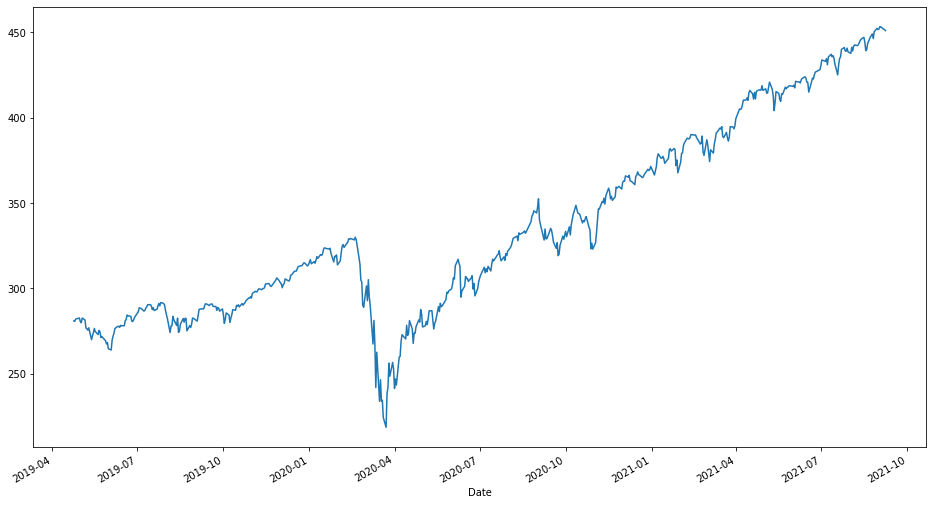

In [4]:
df = qd.fetch("SPY")[-600:]
df["Close"].plot(figsize=(16,9))

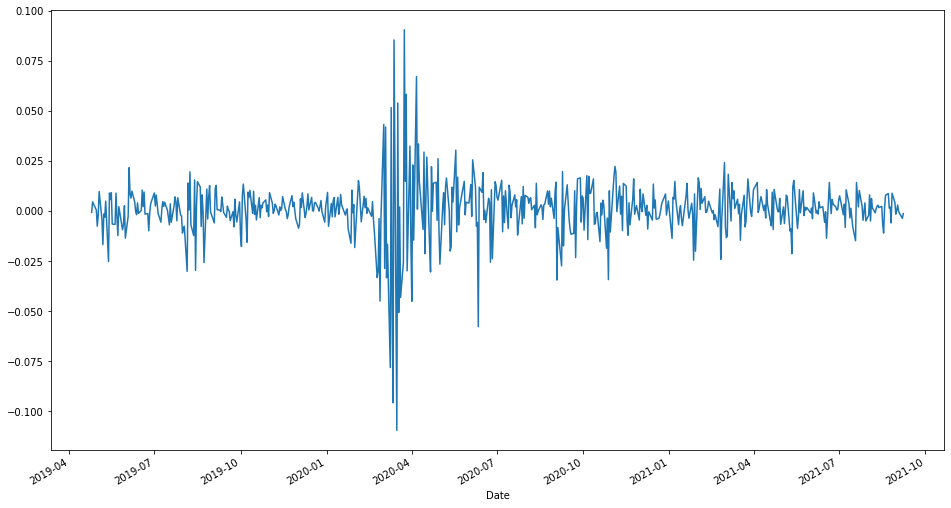

In [5]:
df["Close"].pct_change().plot(figsize=(16,9))

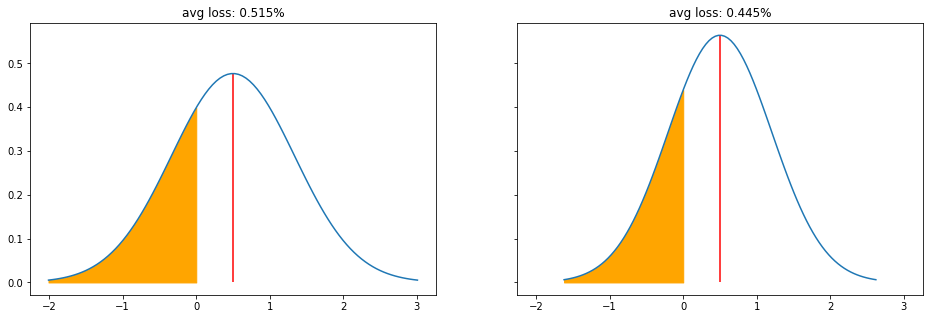

In [6]:
import scipy.stats as stats

mu = 0.5
sigmal = np.sqrt(.7)
sigmar = np.sqrt(.5)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16,5))


xl1 = np.linspace(mu - 3*sigmal, mu + 3*sigmal, 100)
yl1 = stats.norm.pdf(xl1, mu, sigmal)

xl2 = np.linspace(min(xl1), 0, 50)
yl2 = stats.norm.pdf(xl2, mu, sigmal)

alphal = stats.norm.cdf(0, mu, sigmal)
loss_l = alphal**-1 * stats.norm.pdf(stats.norm.ppf(alphal)) * sigmal - mu

ax[0].vlines(mu, 0, max(yl1), color='red')
ax[0].fill_between(xl2, 0, yl2, color='orange')
ax[0].plot(xl1, yl1)
ax[0].set_title(f'avg loss: {loss_l:0.3f}%')


xr1 = np.linspace(mu - 3*sigmar, mu + 3*sigmar, 100)
yr1 = stats.norm.pdf(xr1, mu, sigmar)

xr2 = np.linspace(min(xr1), 0, 50)
yr2 = stats.norm.pdf(xr2, mu, sigmar)

alphar = stats.norm.cdf(0, mu, sigmar)
loss_r = alphal**-1 * stats.norm.pdf(stats.norm.ppf(alphar)) * sigmal - mu


ax[1].vlines(mu, 0, max(yr1), color='red')
ax[1].fill_between(xr2, 0, yr2, color='orange')
ax[1].plot(xr1, yr1)
ax[1].set_title(f'avg loss: {loss_r:0.3f}%')

plt.show()

In [7]:
df = qd.fetch("SPY")

In [8]:
import pandas_ml_quant

with df.model() as m:
    from pandas_ml_utils import FittingParameter
    from pandas_ml_quant import PostProcessedFeaturesAndLabels, PricePredictionSummary
    from pandas_ml_utils_torch import PytorchNN, PytorchModel
    from pandas_ml_common.sampling.splitter import naive_splitter
    from torch.optim import Adam
    from torch import nn
    import torch as t

    # lets build a pretty deep and complex model, just for demonstration
    
    class Net(PytorchNN):

        def __init__(self):
            super().__init__()
            self.l = nn.Sequential(
                nn.Linear(90, 80),
                nn.Tanh(),
                nn.Linear(80, 60),
                nn.Tanh(),
                nn.Linear(60, 40),
                nn.Tanh(),
                nn.Linear(40, 20),
                nn.Tanh(),
                nn.Linear(20, 10),
                nn.Tanh(),
                nn.Linear(10, 1),
                nn.Tanh(),
            )

        def forward_training(self, x):
            return self.l(x)

        def forward_predict(self, x):
            return self.l(x)

    fit_mse = m.fit(
        PytorchModel(
            Net,
            PostProcessedFeaturesAndLabels(
                # use a sliding window of 90 log returns as features
                features=[lambda df: df["Close"].ta.log_returns()],
                feature_post_processor=lambda df: df.ta.rnn(90),
                # predict the log return of one timestep ahead
                labels=[lambda df: df["Close"].ta.log_returns().shift(-1)],
                # indicate that we actaully target non sationary price data
                targets=["Close"]
            ),
            nn.MSELoss,
            Adam,
    
            # pass in a summary provider which helps us to interpret the quality of the fit
            # don't forget to convert the log returns back into simple returns
            summary_provider=PricePredictionSummary.with_reconstructor(
                label_reconstruction=lambda df: df["target"].iloc[:,0],
                predicted_reconstruction=lambda df, y_hat: (df["target"].shift(1).loc[y_hat.index] * np.exp(y_hat.values)).dropna(),
                confidence=0.8,
            )
        ),
        FittingParameter(
            epochs=200,
            # since we use timeseries data we just reserve the trailing 35% as test data
            splitter=naive_splitter(test_size=0.35)
        )
    )

# render the summary provider
fit_mse

Training Data,Test Data
,0
first date,1993-06-09 00:00:00
last date,2011-10-13 00:00:00
events,4624
mse,0.000151
direction correct ratio,0.53936
correlation,0.217757
r^2,0.046506
σ,0.012306
confidence (exp: 0.80),0.854671


In [9]:
df[-400:].model.backtest(
    fit_mse.model, 
    summary_provider=PricePredictionSummary.with_reconstructor(
        label_reconstruction=lambda df: df["target"].iloc[:,0],
        predicted_reconstruction=lambda df, y_hat: (df["target"].shift(1).loc[y_hat.index] * np.exp(y_hat.values)).dropna(),
        confidence=0.8,
    )
)

In [10]:
import pandas_ml_quant

with df.model() as m:
    from pandas_ml_utils import FittingParameter
    from pandas_ml_quant import PostProcessedFeaturesAndLabels, PriceSampledSummary
    from pandas_ml_utils_torch import PytorchNN, PytorchModel, LambdaSplitter
    from pandas_ml_utils_torch.loss import DistributionNLL
    from pandas_ml_utils_torch.utils import wrap_applyable
    from pandas_ml_quant.model.forecast import DistributionForecast
    from pandas_ml_common.sampling.splitter import naive_splitter
    from torch.distributions import Normal
    from torch.optim import Adam
    from torch import nn
    import torch as t

    # lets build a pretty deep and complex model, just for demonstration
    
    class Net(PytorchNN):

        def __init__(self):
            super().__init__()
            self.l = nn.Sequential(
                nn.Linear(90, 80),
                nn.Tanh(),
                nn.Linear(80, 60),
                nn.Tanh(),
                nn.Linear(60, 40),
                nn.Tanh(),
                nn.Linear(40, 20),
                nn.Tanh(),
                nn.Linear(20, 10),
                nn.Tanh(),
                nn.Linear(10, 2),                # <--- NOTE that we have 2 output neurons now !!!
                # return a tuple of 2 tensors for the mean and the standard deviation
                LambdaSplitter(
                    lambda x: x[...,:1],         # <-- predicting the mean
                    lambda x: t.exp(x[...,1:]),  # <-- predicting the standard deviation (need to be positive)
                )
            )

        def forward_training(self, x):
            return self.l(x)

        def forward_predict(self, x):
            # since we predict a tuple of two variables we need to concatenate them into one tensor
            return t.cat(self.l(x), dim=1)
            
        
    fit_vv = m.fit(
        PytorchModel(
            Net,
            PostProcessedFeaturesAndLabels(
                # use a sliding window of 90 log returns as features
                features=[lambda df: df["Close"].ta.log_returns()],
                feature_post_processor=lambda df: df.ta.rnn(90),
                # predict the log return of one timestep ahead
                labels=[lambda df: df["Close"].ta.log_returns().shift(-1)],
                # indicate that we actaully target non sationary price data
                targets=["Close"]
            ),
            lambda: DistributionNLL(lambda y_pred: Normal(*y_pred)),     # <-- NOTE the new loss function  
            Adam,
        
            # pass in a summary provider which helps us to interpret the quality of the fit
            # don't forget to convert the log returns back into simple returns
            summary_provider=PriceSampledSummary.with_reconstructor(
                label_returns=lambda y: np.exp(y) - 1,
                label_reconstruction=lambda y: y.ta.cumlogret(),
                sampler=wrap_applyable(lambda params, samples: Normal(params[...,0], params[...,1]).sample([int(samples.item())]), nr_args=2),
                samples=100,
                confidence=0.8,
            ),
        ),        
        FittingParameter(
            epochs=400,
            # since we use timeseries data we just reserve the trailing 35% as test data
            splitter=naive_splitter(test_size=0.35)
        )
    )

# render the summary provider
fit_vv

Training Data,Test Data
,0
first date,1993-06-09 00:00:00
last date,2011-10-13 00:00:00
events,4624
direction correct ratio of extreme,0.486808
correlation of extreme,-0.103762
r^2 of extreme,-3310.03013
mean(σ),0.025747
confidence (exp: 0.80 %),0.858131
conf width,2.073113


In [11]:
from torch.distributions import Normal

df[-400:].model.backtest(
    fit_vv.model,
    PriceSampledSummary.with_reconstructor(
        label_returns=lambda y: np.exp(y) - 1,
        label_reconstruction=lambda y: y.ta.cumlogret(),
        sampler=wrap_applyable(lambda params, samples: Normal(params[...,0], params[...,1]).sample([int(samples.item())]), nr_args=2),
        samples=100,
        confidence=0.8,
    )
)

(array([  2.,   2.,   1.,   2.,   2.,   2.,   2.,   3.,   5.,  10.,  12.,
          8.,  14.,  15.,  18.,  24.,  30.,  27.,  28.,  42.,  45.,  40.,
         53.,  70.,  95.,  87.,  99., 109., 124., 132., 135., 170., 183.,
        159., 203., 224., 211., 243., 273., 249., 250., 272., 295., 289.,
        321., 279., 283., 314., 288., 287., 310., 274., 279., 252., 245.,
        263., 217., 240., 180., 192., 173., 165., 145., 128., 106., 117.,
         92.,  81.,  76.,  71.,  67.,  31.,  33.,  48.,  30.,  31.,  17.,
         26.,  12.,  12.,   8.,  13.,   7.,   7.,   6.,   2.,   3.,   3.,
          1.,   1.,   3.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.]),
 array([-4.29520567e-02, -4.20195202e-02, -4.10869837e-02, -4.01544472e-02,
        -3.92219106e-02, -3.82893741e-02, -3.73568376e-02, -3.64243011e-02,
        -3.54917646e-02, -3.45592281e-02, -3.36266916e-02, -3.26941551e-02,
        -3.17616186e-02, -3.08290820e-02, -2.98965455e-02, -2.89640090e-02,
        -2.803

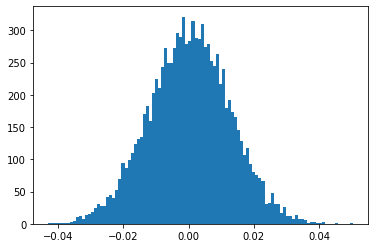

In [12]:
plt.hist(
    np.random.normal(
        *qd.fetch("SPY").model.predict(
            fit_vv.model, 
            tail=1
        )['prediction', 'Close_log_return'].item(),
        10000
    ),
    'sqrt'
)

In [13]:
0.009227 / 0.006861 - 1

0.34484768984113123